<a href="https://colab.research.google.com/github/pysr1/colab_sklearn_workflow/blob/master/sklearnWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sklearn Workflow
### pysr1

### EDA and Data Import

In this first chunk:

* I import the core data science libraries

* Read in California Housing train and test sets

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

Housing_train = pd.read_csv('sample_data/california_housing_train.csv')
Housing_test = pd.read_csv('sample_data/california_housing_train.csv')

The widget below can be used to view the a plot of the 

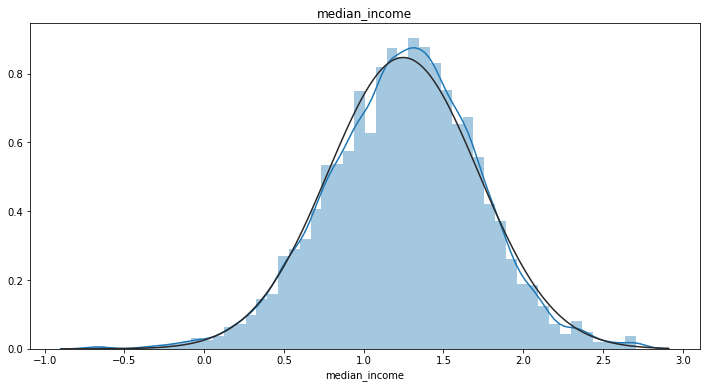

In [43]:
#@title Histogram Viewer
variable_name = "median_income" #@param ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income","median_house_value"]
log_trans = "True" #@param ["True", "False"]

from scipy.stats import norm 

plt.figure(figsize = (12, 6))
col = variable_name

if log_trans == "False":
  sns.distplot(Housing_train[variable_name], fit = norm)
  plt.title(col)
  plt.show()
  
else:
  if min(Housing_train[col]) > 0:
    sns.distplot(np.log(Housing_train[variable_name]), fit = norm)
    plt.title(col)
    plt.show()
  else:
    sns.distplot(np.log1p(Housing_train[variable_name]), fit = norm)
    plt.title(col)
    plt.show()
    
  

#### I've decided to log transform these variables for variance stabilization:

In [0]:
to_log = ['median_income','total_bedrooms', 'total_rooms', 'median_house_value', 'population']

for col in to_log:
  if min(Housing_train[col]) > 0:
    
    Housing_train[col] = np.log1p(Housing_train[col])
    Housing_test[col] = np.log1p(Housing_test[col])
  
  else:
    
    Housing_train[col] = np.log(Housing_train[col])
    Housing_test[col] = np.log(Housing_test[col])  

In [45]:
X = "households" #@param ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
y = "housing_median_age" #@param ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income","median_house_value"]

import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

p = figure(plot_width=1000, plot_height=400, title = "{} vs {}".format(X, y) )

# add a circle renderer with a size, color, and alpha
p.circle(Housing_train[X], Housing_train[y], alpha=0.5)
 
# show the results
show(p)




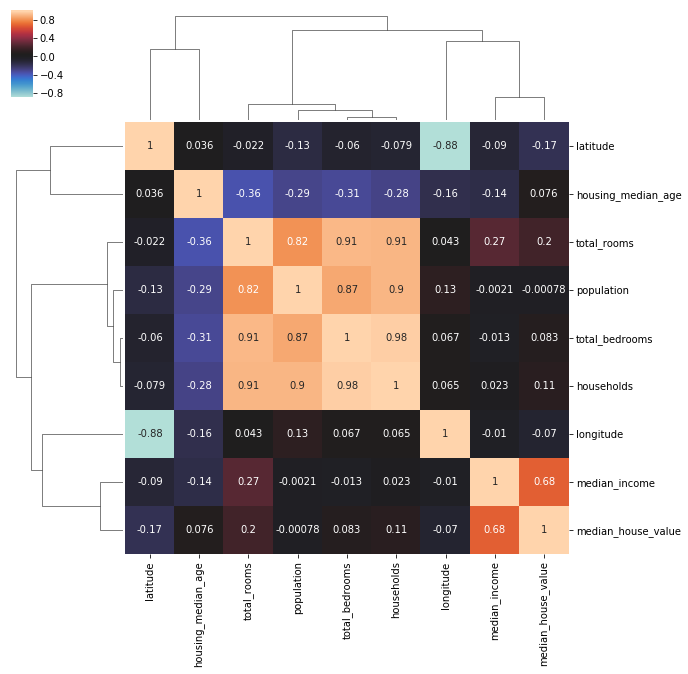

In [46]:
cormat = Housing_train.corr(method = "spearman")
ax = sns.clustermap(cormat, annot= True, center = np.median(cormat))
plt.show()

### Modeling

In [0]:
X_train = Housing_train.drop('median_house_value', 1)
X_test = Housing_test.drop('median_house_value', 1)
y_train = Housing_train['median_house_value']
y_test = Housing_test['median_house_value']

#### first model: Simple linear model

Let's start of our modeling by trying a simple ridge regression model.  It's honestly a bit unfair to use linear regression as a baseline for machine learning problems because the method was created with inference in mind, not prediciton.  We'll introduce an l2 penalty to our coefficients, This helps our model predict and generalize across different samples better.

In [48]:
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


basic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(scoring = 'neg_mean_absolute_error'))])

basic_pipe = basic_pipe.fit(X_train, y_train)


from sklearn.metrics import r2_score
preds = basic_pipe.predict(X_test)
r2_score(y_test, preds)

0.6919948857822629

In [0]:
from sklearn.utils import resample

ridge = basic_pipe.named_steps['ridge']

basic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha = ridge.alpha_))])

# Get bootstrap standard error 
err = np.std([basic_pipe.fit(*resample(X_train, y_train)).named_steps['ridge'].coef_
              for i in range(2000)], 0)

coefs = pd.DataFrame({'column': X_train.columns, 'coef' : ridge.coef_, 'std' : err}).sort_values('coef')

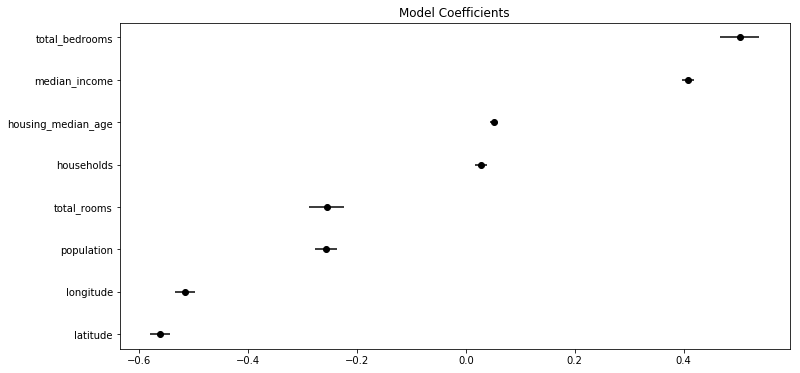

In [50]:
plt.figure(figsize = (12, 6))
plt.errorbar(coefs['coef'], coefs['column'],  xerr= 1.96 * coefs['std'], fmt = "ko")
plt.title('Model Coefficients')
plt.show()

We're much more certain of the standardized effect size for housing_median_age than we are other coefficients